In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample

# Download and explore the dataset
import kagglehub
path = kagglehub.dataset_download("quynhlecl/lung-cancer-x-ray")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/quynhlecl/lung-cancer-x-ray/versions/1


In [28]:
root_dataset_path = "/root/.cache/kagglehub/datasets/quynhlecl/lung-cancer-x-ray/versions/1/chest_xray_lung/"
train_dataset_path = os.path.join(root_dataset_path, "train")
test_dataset_path = os.path.join(root_dataset_path, "test")
val_dataset_path = os.path.join(root_dataset_path, "val")

In [29]:
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")
    return class_counts

class_counts = explore_dataset(root_dataset_path)

Dataset Overview:
Total Classes: 6
Total Images: 11727
Class Distribution:
  test: 2
  val: 2
  train: 2
  chest_xray: 3
  NORMAL: 1341
  Cancer: 3875


In [30]:
# Calculate class weights
classes = list(class_counts.keys())
y = np.concatenate([[cls] * count for cls, count in class_counts.items()])
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(classes, class_weights))
print("Class Weights:", class_weights)

Class Weights: {'test': 0.22473118279569892, 'val': 0.649391001739995, 'train': 290.27777777777777, 'chest_xray': 435.4166666666667, 'NORMAL': 435.4166666666667, 'Cancer': 435.4166666666667}


<ipython-input-31-2640a22b92e5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


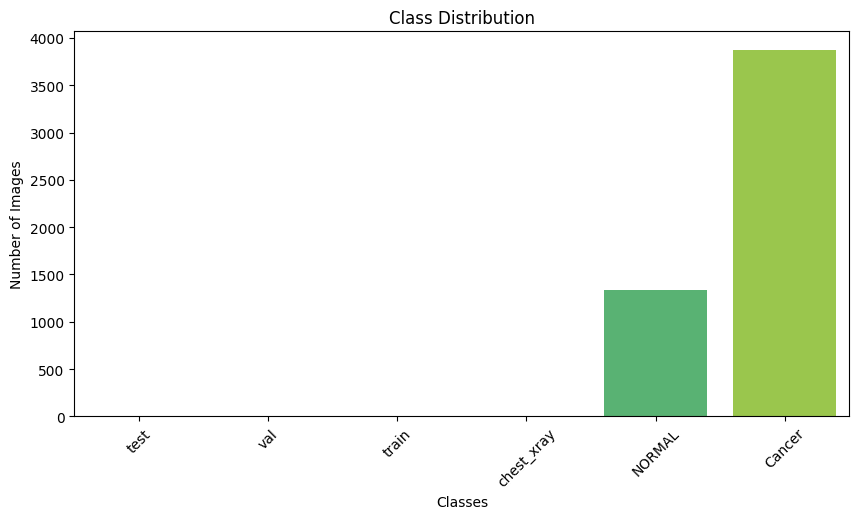

In [31]:
# Plot class distribution
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(class_counts)


In [32]:
# Data Generators
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_directory(
    train_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)
val_generator = val_test_gen.flow_from_directory(
    val_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)
test_generator = val_test_gen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:
# Model Definition using ResNet50
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23850242 (90.98 MB)
Trainable params: 262530 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [36]:
from sklearn.model_selection import KFold

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)


def extract_data_and_labels(generator):
    data = []
    labels = []
    for _ in range(len(generator)):
        images, batch_labels = generator.next()
        data.append(images)
        labels.append(batch_labels)
    return np.vstack(data), np.concatenate(labels)

# Extract data and labels
train_data, train_labels = extract_data_and_labels(train_generator)

# Initialize KFold
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
fold_no = 1
for train_idx, val_idx in kfold.split(train_data, train_labels):
    print(f"Training Fold {fold_no}...")

    # Create data generators for the current fold
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(
        train_data[train_idx], train_labels[train_idx], batch_size=32
    )
    val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(
        train_data[val_idx], train_labels[val_idx], batch_size=32
    )

    # Create a new model instance
    model = create_model()

    # Train the model
    history = model.fit(
        train_data_gen,
        epochs=3,
        validation_data=val_data_gen,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model
    val_loss, val_acc = model.evaluate(val_data_gen)
    print(f"Fold {fold_no} - Validation Accuracy: {val_acc:.2f}")

    fold_no += 1


Training Fold 1...
Epoch 1/3
82/82 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 911s 11s/step - loss: 0.2786 - accuracy: 0.8869 - val_loss: 0.1682 - val_accuracy: 0.9310
Epoch 2/3
82/82 [==============================] - 892s 11s/step - loss: 0.1876 - accuracy: 0.9233 - val_loss: 0.2097 - val_accuracy: 0.9107
Epoch 3/3
82/82 [==============================] - 442s 5s/step - loss: 0.1341 - accuracy: 0.9490
Fold 1 - Validation Accuracy: 0.95
Training Fold 2...
Epoch 1/3
82/82 [==============================] - 893s 11s/step - loss: 0.2672 - accuracy: 0.8900 - val_loss: 0.1687 - val_accuracy: 0.9317
Epoch 2/3
82/82 [==============================] - 887s 11s/step - loss: 0.1696 - accuracy: 0.9317 - val_loss: 0.1415 - val_accuracy: 0.9421
Epoch 3/3
82/82 [==============================] - 446s 5s/step - loss: 0.1193 - accuracy: 0.9525
Fold 2 - Validation Accuracy: 0.95


20/20 [==============================] - 109s 5s/step - loss: 0.2645 - accuracy: 0.8926
Test Accuracy: 0.89
20/20 [==============================] - 111s 5s/step
              precision    recall  f1-score   support

      Cancer       0.94      0.89      0.91       390
      NORMAL       0.83      0.90      0.86       234

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.89       624
weighted avg       0.90      0.89      0.89       624

AUC-ROC: 0.89


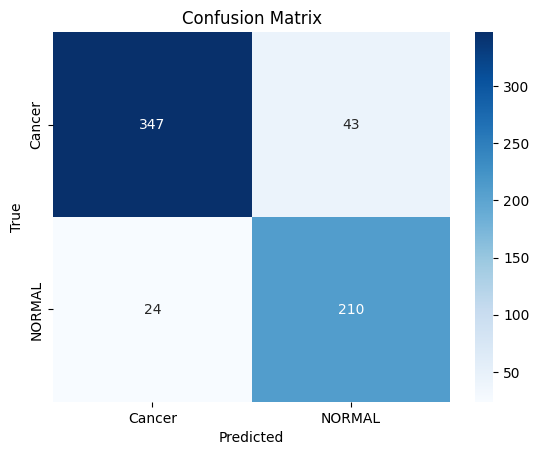

In [37]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Classification Report
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# AUC-ROC Score
auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
print(f"AUC-ROC: {auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 7s 7s/step


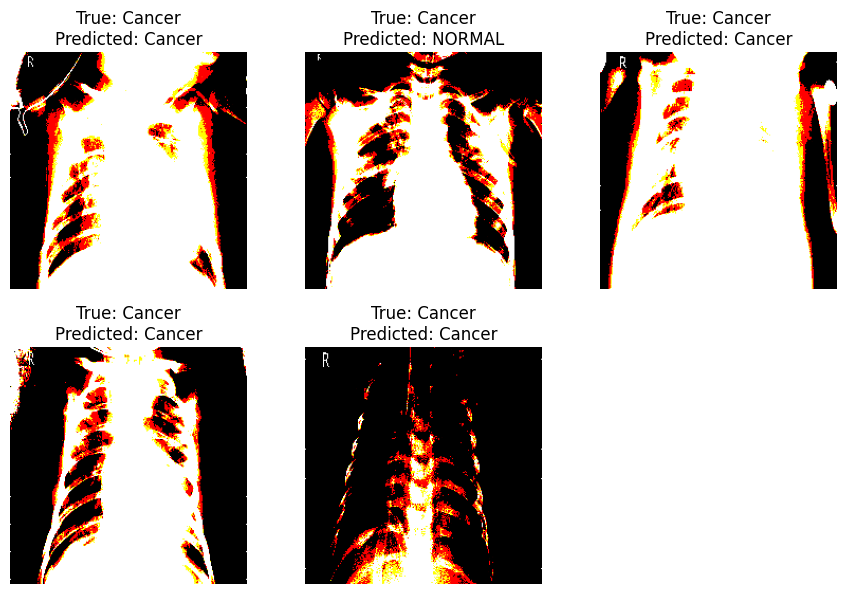

In [38]:
# Visualize Predictions
def visualize_predictions(generator, model, num_images=5):
    images, true_labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(9, 9))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[int(true_labels[i])]}\nPredicted: {class_names[predicted_labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_generator, model, num_images=5)